### Machine Learning Engineer Nanodegree


## Capstone Project
## Vision-Perception Module - Situational Awareness System for Autonomous Vehicles
## 02 - Apply SVM

Kamil Kaczmarczyk
September 10th, 2017
***

## Import & Initialize

In [1]:
### Import the libraries

import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import os
import time
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from scipy.ndimage.measurements import label
from scipy.misc import imresize
import tensorflow as tf

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import codecs

%matplotlib inline

print("END")

END


## Read the dataset

In [2]:
# Write Images Paths in files

#Aircraft images
basedir = 'dataset_v2/aircraft_1/'
aircraft = []
aircraft.extend(glob.glob(basedir+'/*'))
print('Number of aircraft images found: {}'.format(len(aircraft)))
        
#Birds images
basedir = 'dataset_v2/birds_1/'
birds = []
birds.extend(glob.glob(basedir+'/*'))
print('Number of birds images found: {}'.format(len(birds)))
        
#Sky images     
basedir = 'dataset_v2/sky_1/'
sky = []
sky.extend(glob.glob(basedir+'/*'))
print('Number of sky images found: {}'.format(len(sky)))

#Ground images     
basedir = 'dataset_v2/ground_1/'
ground = []
ground.extend(glob.glob(basedir+'/*'))
print('Number of ground images found: {}'.format(len(ground)))
        
print("END")

Number of aircraft images found: 400
Number of birds images found: 367
Number of sky images found: 407
Number of ground images found: 407
END


## Define Preprocessing Functions 

In [3]:
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

In [4]:
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [5]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [6]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, vis=False):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            if vis == True:
                hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=True, feature_vec=True)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
                
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    if vis == True:
        return np.concatenate(img_features), hog_image
    else:
        return np.concatenate(img_features)

In [7]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [8]:
#plotting multiple images - based on the tutorial
def visualize(fig, rows, cols, imgs, titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])

In [9]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [10]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [11]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    #on_windows = []
    on_windows_aircraft = []
    on_windows_birds = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (300, 210))
        
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 2: #class aircraft
            on_windows_aircraft.append(window)
        elif prediction == 1: #class bird
            on_windows_birds.append(window)
        
    #labels shall be 2 - aircraft, 1 - bird(s) and 0 - environment
    #8) Return windows for positive detections
    return on_windows_aircraft, on_windows_birds

In [12]:
# function for converting color spaces
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

## Extract Features for Sampled Images (run only once) 

In [13]:
# Use HOG on sample images from the dataset

%matplotlib inline

#random indices selection
aircraft_ind = np.random.randint(0, len(aircraft))
birds_ind = np.random.randint(0, len(birds))
sky_ind = np.random.randint(0, len(sky))
ground_ind = np.random.randint(0, len(ground))

#read images
aircraft_image = mpimg.imread(aircraft[aircraft_ind])
birds_image = mpimg.imread(birds[birds_ind])
sky_image = mpimg.imread(sky[sky_ind])
ground_image = mpimg.imread(ground[ground_ind])

#tweak these parameters and see how the results change.
color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
#orient = 9  # HOG orientations
orient = 6  # HOG orientations
#pix_per_cell = 8 # HOG pixels per cell
pix_per_cell = 15 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
#spatial_size = (48, 48) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

aircraft_features, aircraft_hog_image = single_img_features(aircraft_image, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat, vis=True)
birds_features, birds_hog_image = single_img_features(birds_image, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat, vis=True)
sky_features, sky_hog_image = single_img_features(sky_image, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat, vis=True)
ground_features, ground_hog_image = single_img_features(ground_image, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat, vis=True)

print("END")

END


END


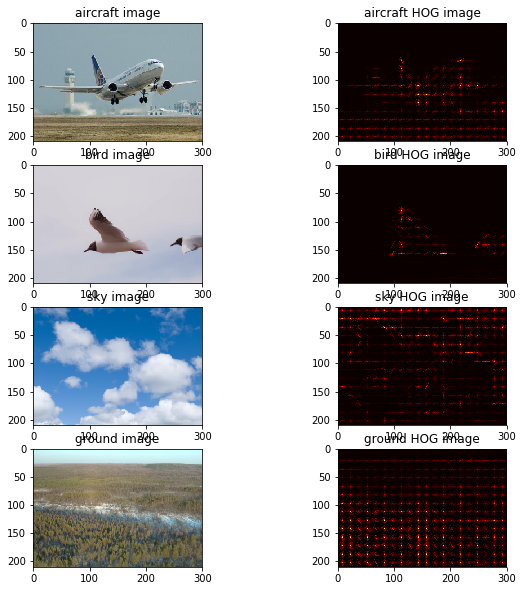

In [14]:
# Plot Sample Images and their HOG features

images = [aircraft_image, aircraft_hog_image, birds_image, birds_hog_image, sky_image, sky_hog_image, ground_image, ground_hog_image]
titles = ['aircraft image', 'aircraft HOG image', 'bird image', 'bird HOG image', 'sky image', 'sky HOG image', 'ground image', 'ground HOG image']

fig = plt.figure(figsize=(10,10))
visualize(fig, 4, 2, images, titles)
for i, img in enumerate(images):
    plt.imsave('output_images_v2/'+titles[i]+'.png', images[i]*255)
    
print("END")

## Train the Model 

In [15]:
#tweak these parameters and see how the results change.
#color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
#orient = 6  # HOG orientations
orient = 9  # HOG orientations
#pix_per_cell = 8 # HOG pixels per cell
pix_per_cell = 15 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
#hog_channel = 0 # Can be 0, 1, 2, or "ALL"
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
#spatial_size = (16, 16) # Spatial binning dimensions
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
#y_start_stop = [None, None] # Min and max in y to search in slide_window()

t=time.time()

test_aircraft = aircraft
test_birds = birds
test_sky = sky
test_ground = ground

# Train the Model - only on a subset of samples
#n_samples = 1000
#n_samples = 3
#max_size = 1222
#random_idxs = np.random.randint(0,max_size, n_samples)
#test_aircraft = np.array(aircraft)[random_idxs]
#test_birds = np.array(birds)[random_idxs]
#test_environment = np.array(environment)[random_idxs]

aircraft_features = extract_features(test_aircraft, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
birds_features = extract_features(test_birds, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
sky_features = extract_features(test_sky, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
ground_features = extract_features(test_ground, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

print(time.time()-t, 'Seconds to compute features...')

X = np.vstack((aircraft_features, birds_features, sky_features, ground_features)).astype(np.float64)    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

#labels shall be 2 - aircraft, 1 - bird(s), 0 - sky and -1 - ground


aircraft_labels = np.empty(len(aircraft_features))
aircraft_labels.fill(2)
birds_labels = np.ones(len(birds_features))
sky_labels = np.zeros(len(sky_features))
ground_labels = np.empty(len(ground_features))
ground_labels.fill(-1)

# Define the labels vector
y = np.hstack((aircraft_labels, birds_labels, sky_labels, ground_labels))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
#X_train, X_test, y_train, y_test = train_test_split(
#    scaled_X, y, test_size=0.2, random_state=rand_state)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.1, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

print("END")

255.83215713500977 Seconds to compute features...
Using: 9 orientations 15 pixels per cell and 2 cells per block
Feature vector length: 29796
104.91 Seconds to train SVC...
Test Accuracy of SVC =  0.8805
END


## Perform a test on test images 

In [16]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def just_classify_SVM(img, window, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (300, 210))

    #Extract features for that window using single_img_features()
    features = single_img_features(test_img, color_space=color_space, 
                    spatial_size=spatial_size, hist_bins=hist_bins, 
                    orient=orient, pix_per_cell=pix_per_cell, 
                    cell_per_block=cell_per_block, 
                    hog_channel=hog_channel, spatial_feat=spatial_feat, 
                    hist_feat=hist_feat, hog_feat=hog_feat)
    
    #Scale extracted features to be fed to classifier
    test_features = scaler.transform(np.array(features).reshape(1, -1))
    
    #Predict using your classifier
    guess = clf.predict(test_features)
    
    return guess

In [21]:
def detect_objects_SVM(img, scales, overlap, mask=None):
    
    heatmap_aircraft = np.zeros_like(img[:,:,0])
    heatmap_birds = np.zeros_like(img[:,:,0])
    
    for scale in scales:
        xy_window = int(img.shape[1]*scale)
        if mask is not None:
            x_start_stop = [mask[1][0], mask[1][1]]
            y_start_stop = [mask[0][0], mask[0][1]]
            #assume x > y in terms of image shape - scaling done in-line with x-dimension
            windows = slide_window(img, x_start_stop, y_start_stop, 
                        xy_window=(xy_window, xy_window), xy_overlap=(overlap, overlap))
        else:
            windows = slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                        xy_window=(xy_window, xy_window), xy_overlap=(overlap, overlap))
        
        for window in windows:
            
            #window_img = img[window[0][1]:window[1][1], window[0][0]:window[1][0]]
            #guess = just_classify(window_img)
            
            guess = just_classify_SVM(img, window, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
            
            if guess == 2: #aircraft
                heatmap_aircraft[window[0][1]:window[1][1], window[0][0]:window[1][0]] += 1
            elif guess == 1: #birds
                heatmap_birds[window[0][1]:window[1][1], window[0][0]:window[1][0]] += 1
                
    #return draw_img, heatmap_aircraft, heatmap_birds
    return heatmap_aircraft, heatmap_birds

In [18]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [22]:
searchpath = 'test_images_2/*'  
example_images = glob.glob(searchpath)

scales = [1, 0.4, 0.2, 0.1]
overlap = 0.5

out_images = []
out_heatmap_aircraft = []
out_heatmap_birds = []

for img_src in example_images:
    
    img = mpimg.imread(img_src)
    heatmap_aircraft, heatmap_birds = detect_objects_SVM(img, scales, overlap)
    
    out_images.append(img)
    out_images.append(heatmap_aircraft)
    out_images.append(heatmap_birds)
    
    out_heatmap_aircraft.append(heatmap_aircraft)
    out_heatmap_birds.append(heatmap_birds)    

In [23]:
#visualize function but without titles
#def visualize(fig, rows, cols, imgs, titles):
def just_visualize(fig, rows, cols, imgs):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap='hot')
        else:
            plt.imshow(img)

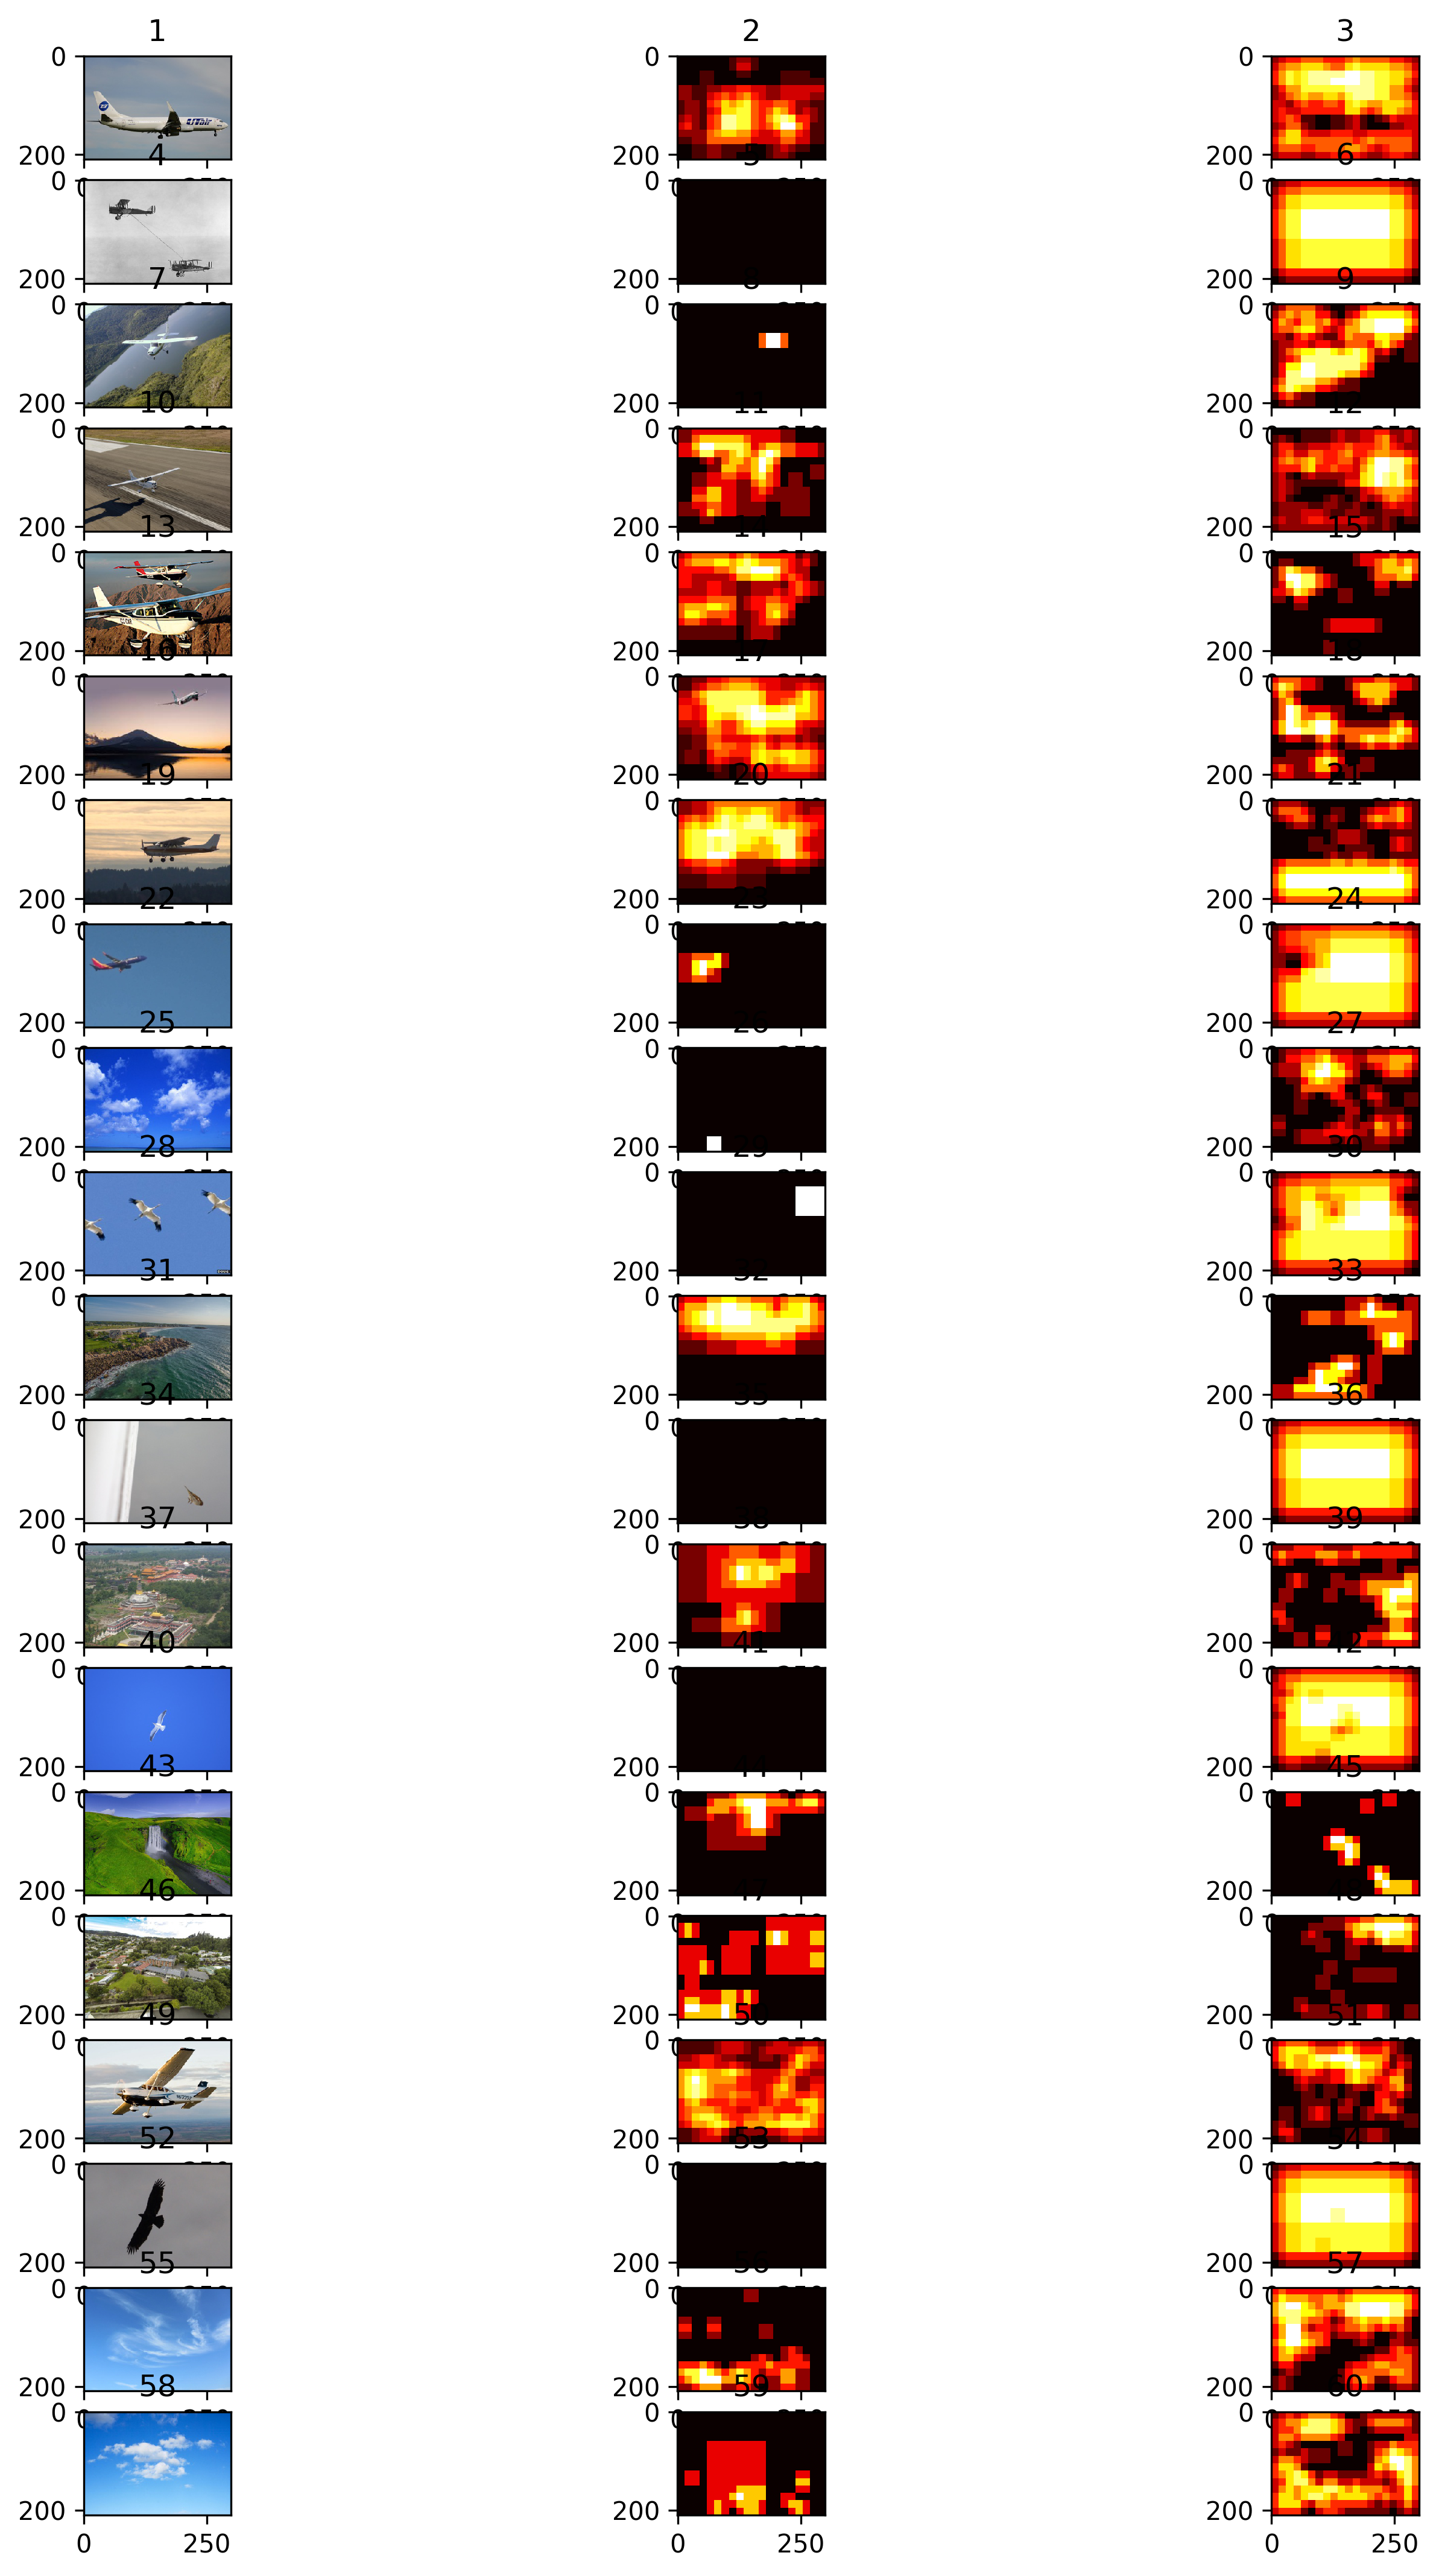

In [24]:
fig = plt.figure(figsize=(12,18), dpi=300)
just_visualize(fig, len(example_images), 3, out_images)

# Column 1 - original test image |
# Column 2 - aircraft detections heatmap |
# Column 3 - birds detections heatmap 

In [25]:
#plt.imshow(window_img)
for i, img in enumerate(out_images):
    plt.imsave('test_images_results/out_images_0_SVM/'+str(i+1)+'.png',out_images[i])

## Apply Thresholds to heatmaps

In [44]:
threshold_aircraft = 2
threshold_birds = 7

out_images_th = []
out_heatmap_aircraft_th = []
out_heatmap_birds_th = []
i=0

for img_src in example_images:
    
    img = mpimg.imread(img_src)
    
    heatmap_aircraft = out_heatmap_aircraft[i]
    heatmap_aircraft_th = apply_threshold(heatmap_aircraft, threshold_aircraft)
    out_heatmap_aircraft_th.append(heatmap_aircraft_th)
    
    heatmap_birds = out_heatmap_birds[i]
    heatmap_birds_th = apply_threshold(heatmap_birds, threshold_birds)
    out_heatmap_birds_th.append(heatmap_birds_th) 
    
    out_images_th.append(img)
    out_images_th.append(heatmap_aircraft_th)
    out_images_th.append(heatmap_birds_th)
    
    i+=1

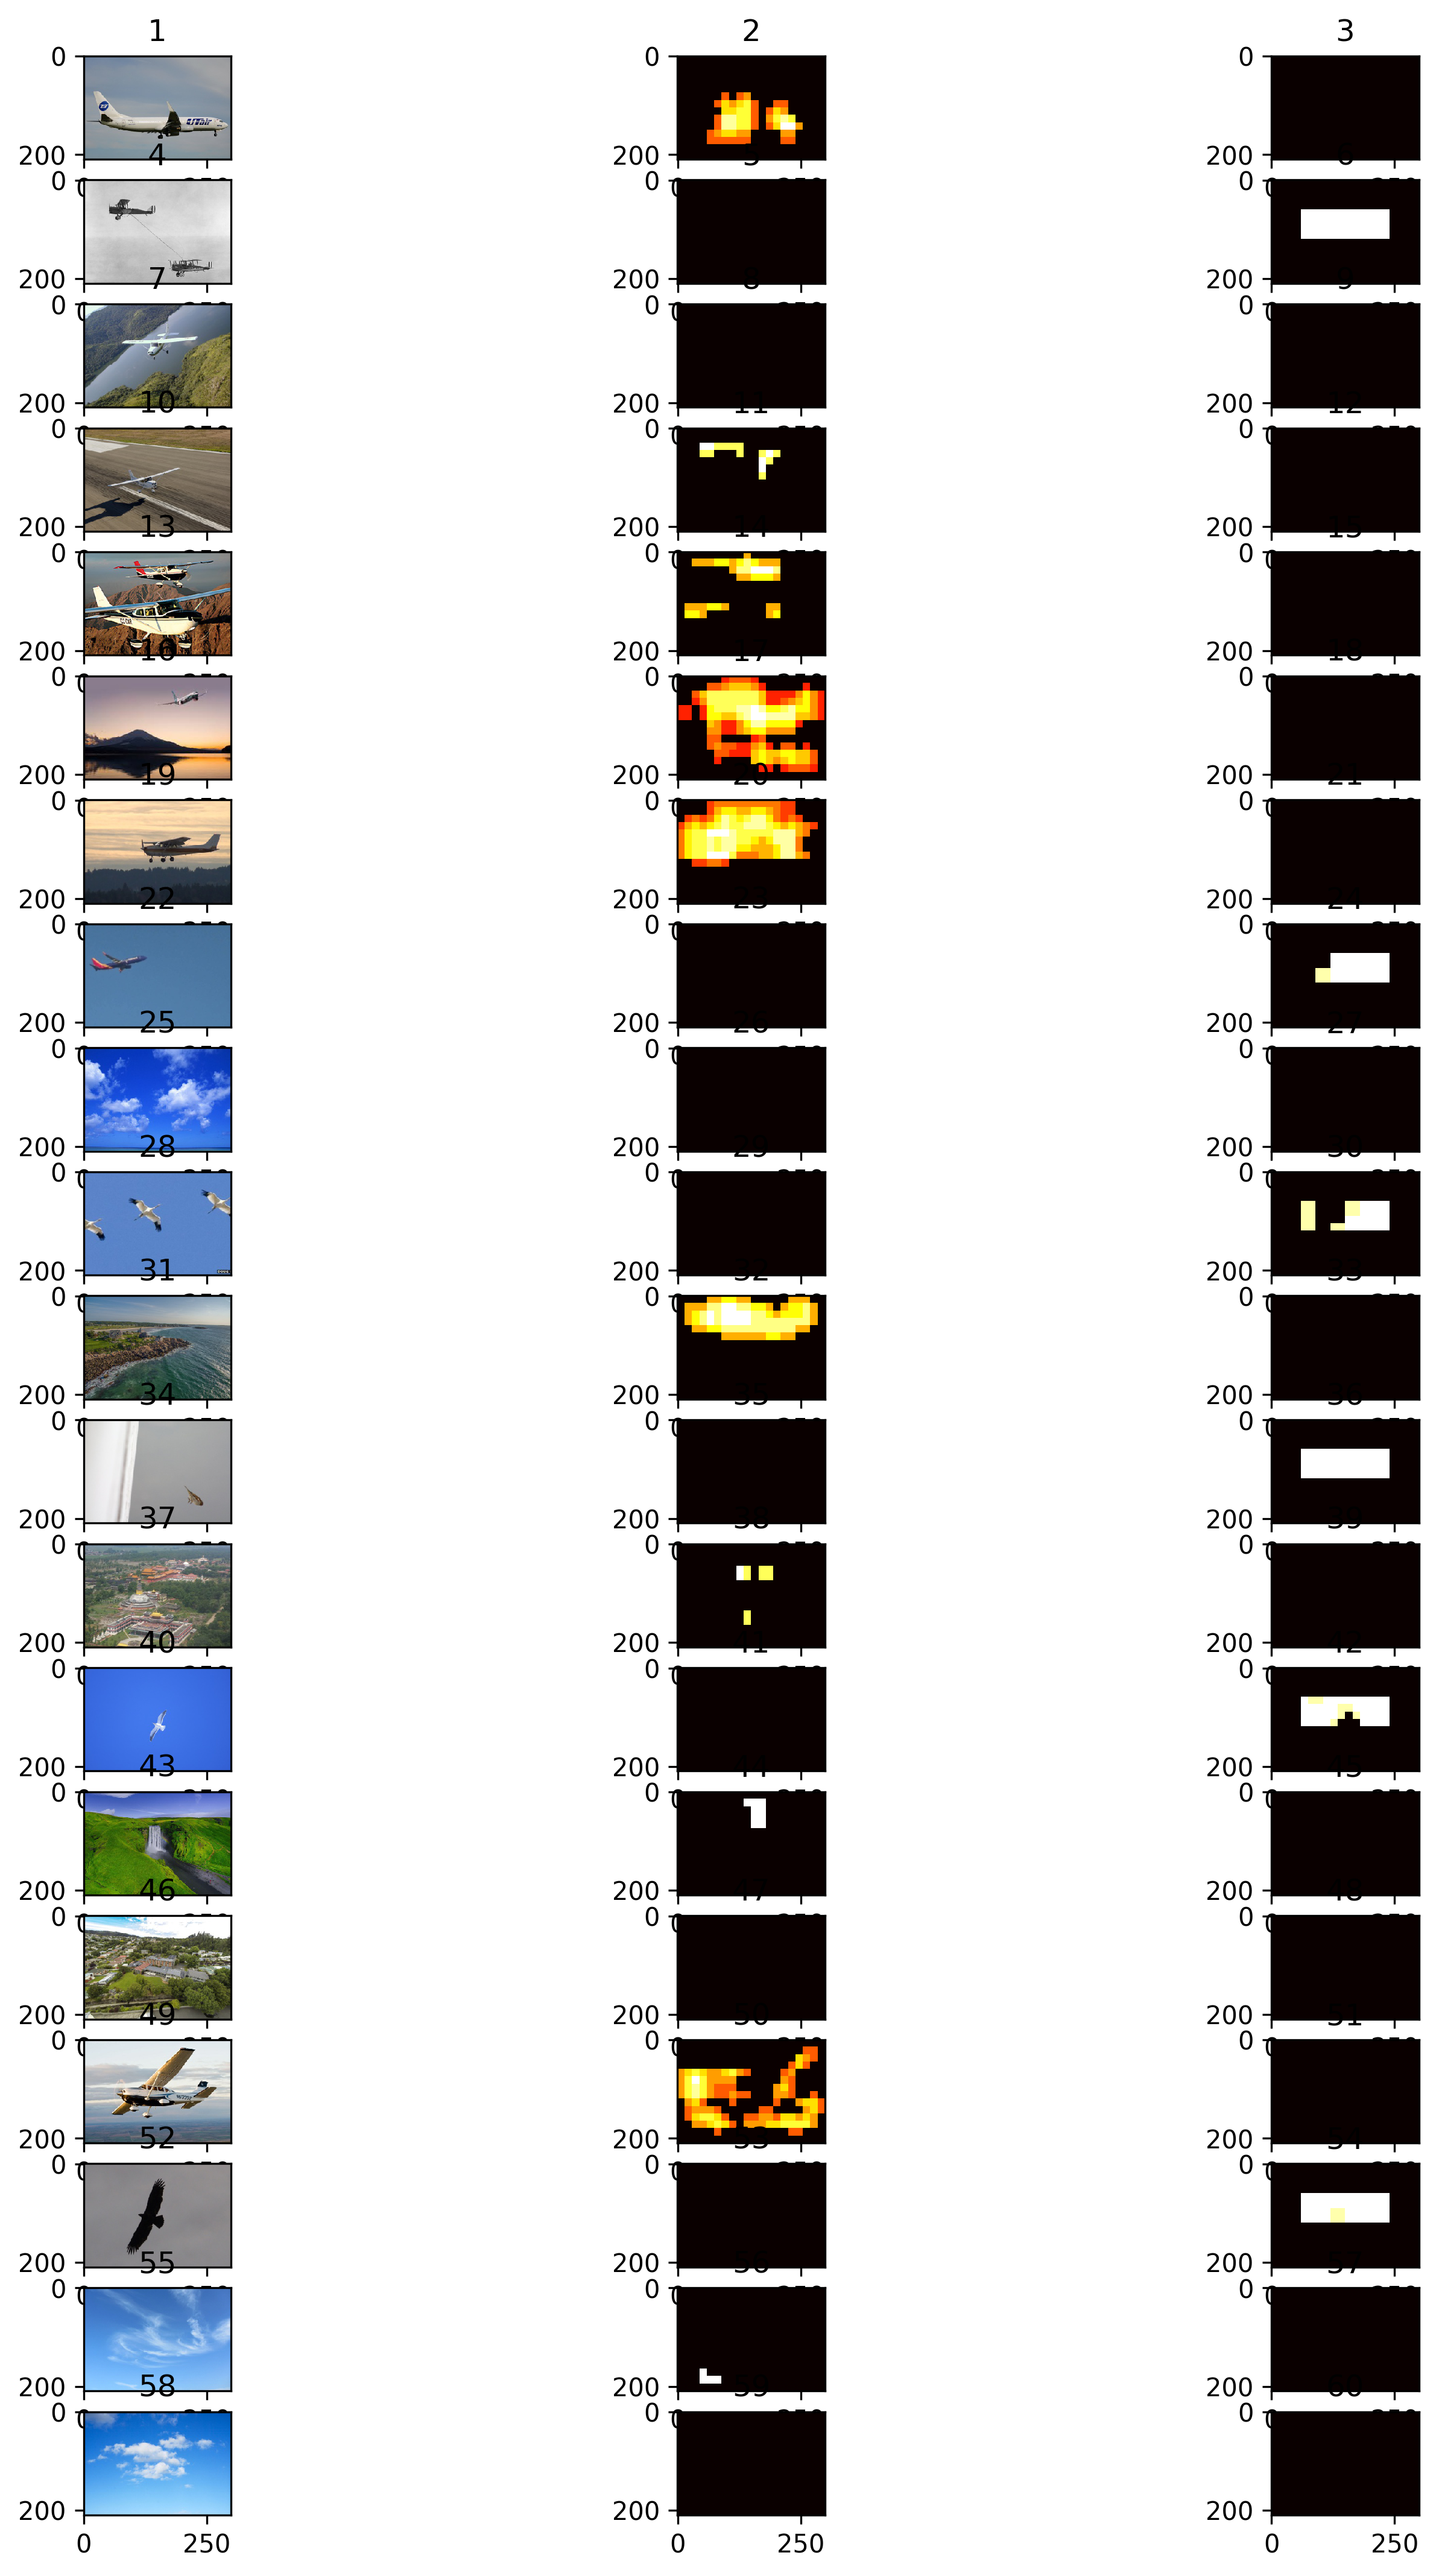

In [45]:
fig = plt.figure(figsize=(12,18), dpi=300)
just_visualize(fig, len(example_images), 3, out_images_th)

# Column 1 - original test image |
# Column 2 - aircraft detections heatmap - thresholded | 
# Column 3 - birds detections heatmap - thresholded

In [46]:
#plt.imshow(window_img)
for i, img in enumerate(out_images_th):
    plt.imsave('test_images_results/out_images_th_1_SVM/'+str(i+1)+'.png',out_images_th[i])

## Draw bounding boxes around heatmap hotspots 

In [47]:
def draw_labeled_bboxes(img, labels, color):
    # Iterate through all detected cars
    bboxes = []
    for object_number in range(1, labels[1]+1):
        # Find pixels with each object_number label value
        nonzero = (labels[0] == object_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        bboxes.append(bbox)
        cv2.rectangle(img, bbox[0], bbox[1], color, 6)
    # Return the image
    
    # Ensure variable is defined
    try:
        bbox
    except NameError:
        bbox = None

    return img, bbox

In [48]:
from scipy.ndimage.measurements import label
import cv2

out_images_labels = []
i = 0
color_aircraft = (0,0,255)
color_birds = (0,255,0)

for img_src in example_images:

    img = mpimg.imread(img_src)
    
    heatmap_aircraft_th = out_heatmap_aircraft_th[i]
    labels_aircraft = label(heatmap_aircraft_th)
    draw_img_aircraft, bbox_aircraft = draw_labeled_bboxes(np.copy(img), labels_aircraft, color_aircraft)
    
    #to avoid many false alerts in detecting sky as birds subtract from the birds heatmap the bounding boxes of aircraft
    heatmap_birds_th = out_heatmap_birds_th[i]

    #if bbox_aircraft is not None:
    #    heatmap_birds_th[bbox_aircraft[0][1]:bbox_aircraft[1][1], bbox_aircraft[0][0]:bbox_aircraft[1][0]] = 0

    labels_birds = label(heatmap_birds_th)
    draw_img_birds, bbox_birds = draw_labeled_bboxes(np.copy(img), labels_birds, color_birds)
    
    out_images_labels.append(img)
    out_images_labels.append(draw_img_aircraft)
    out_images_labels.append(heatmap_aircraft_th)
    out_images_labels.append(draw_img_birds)
    out_images_labels.append(heatmap_birds_th)    
    
    i += 1

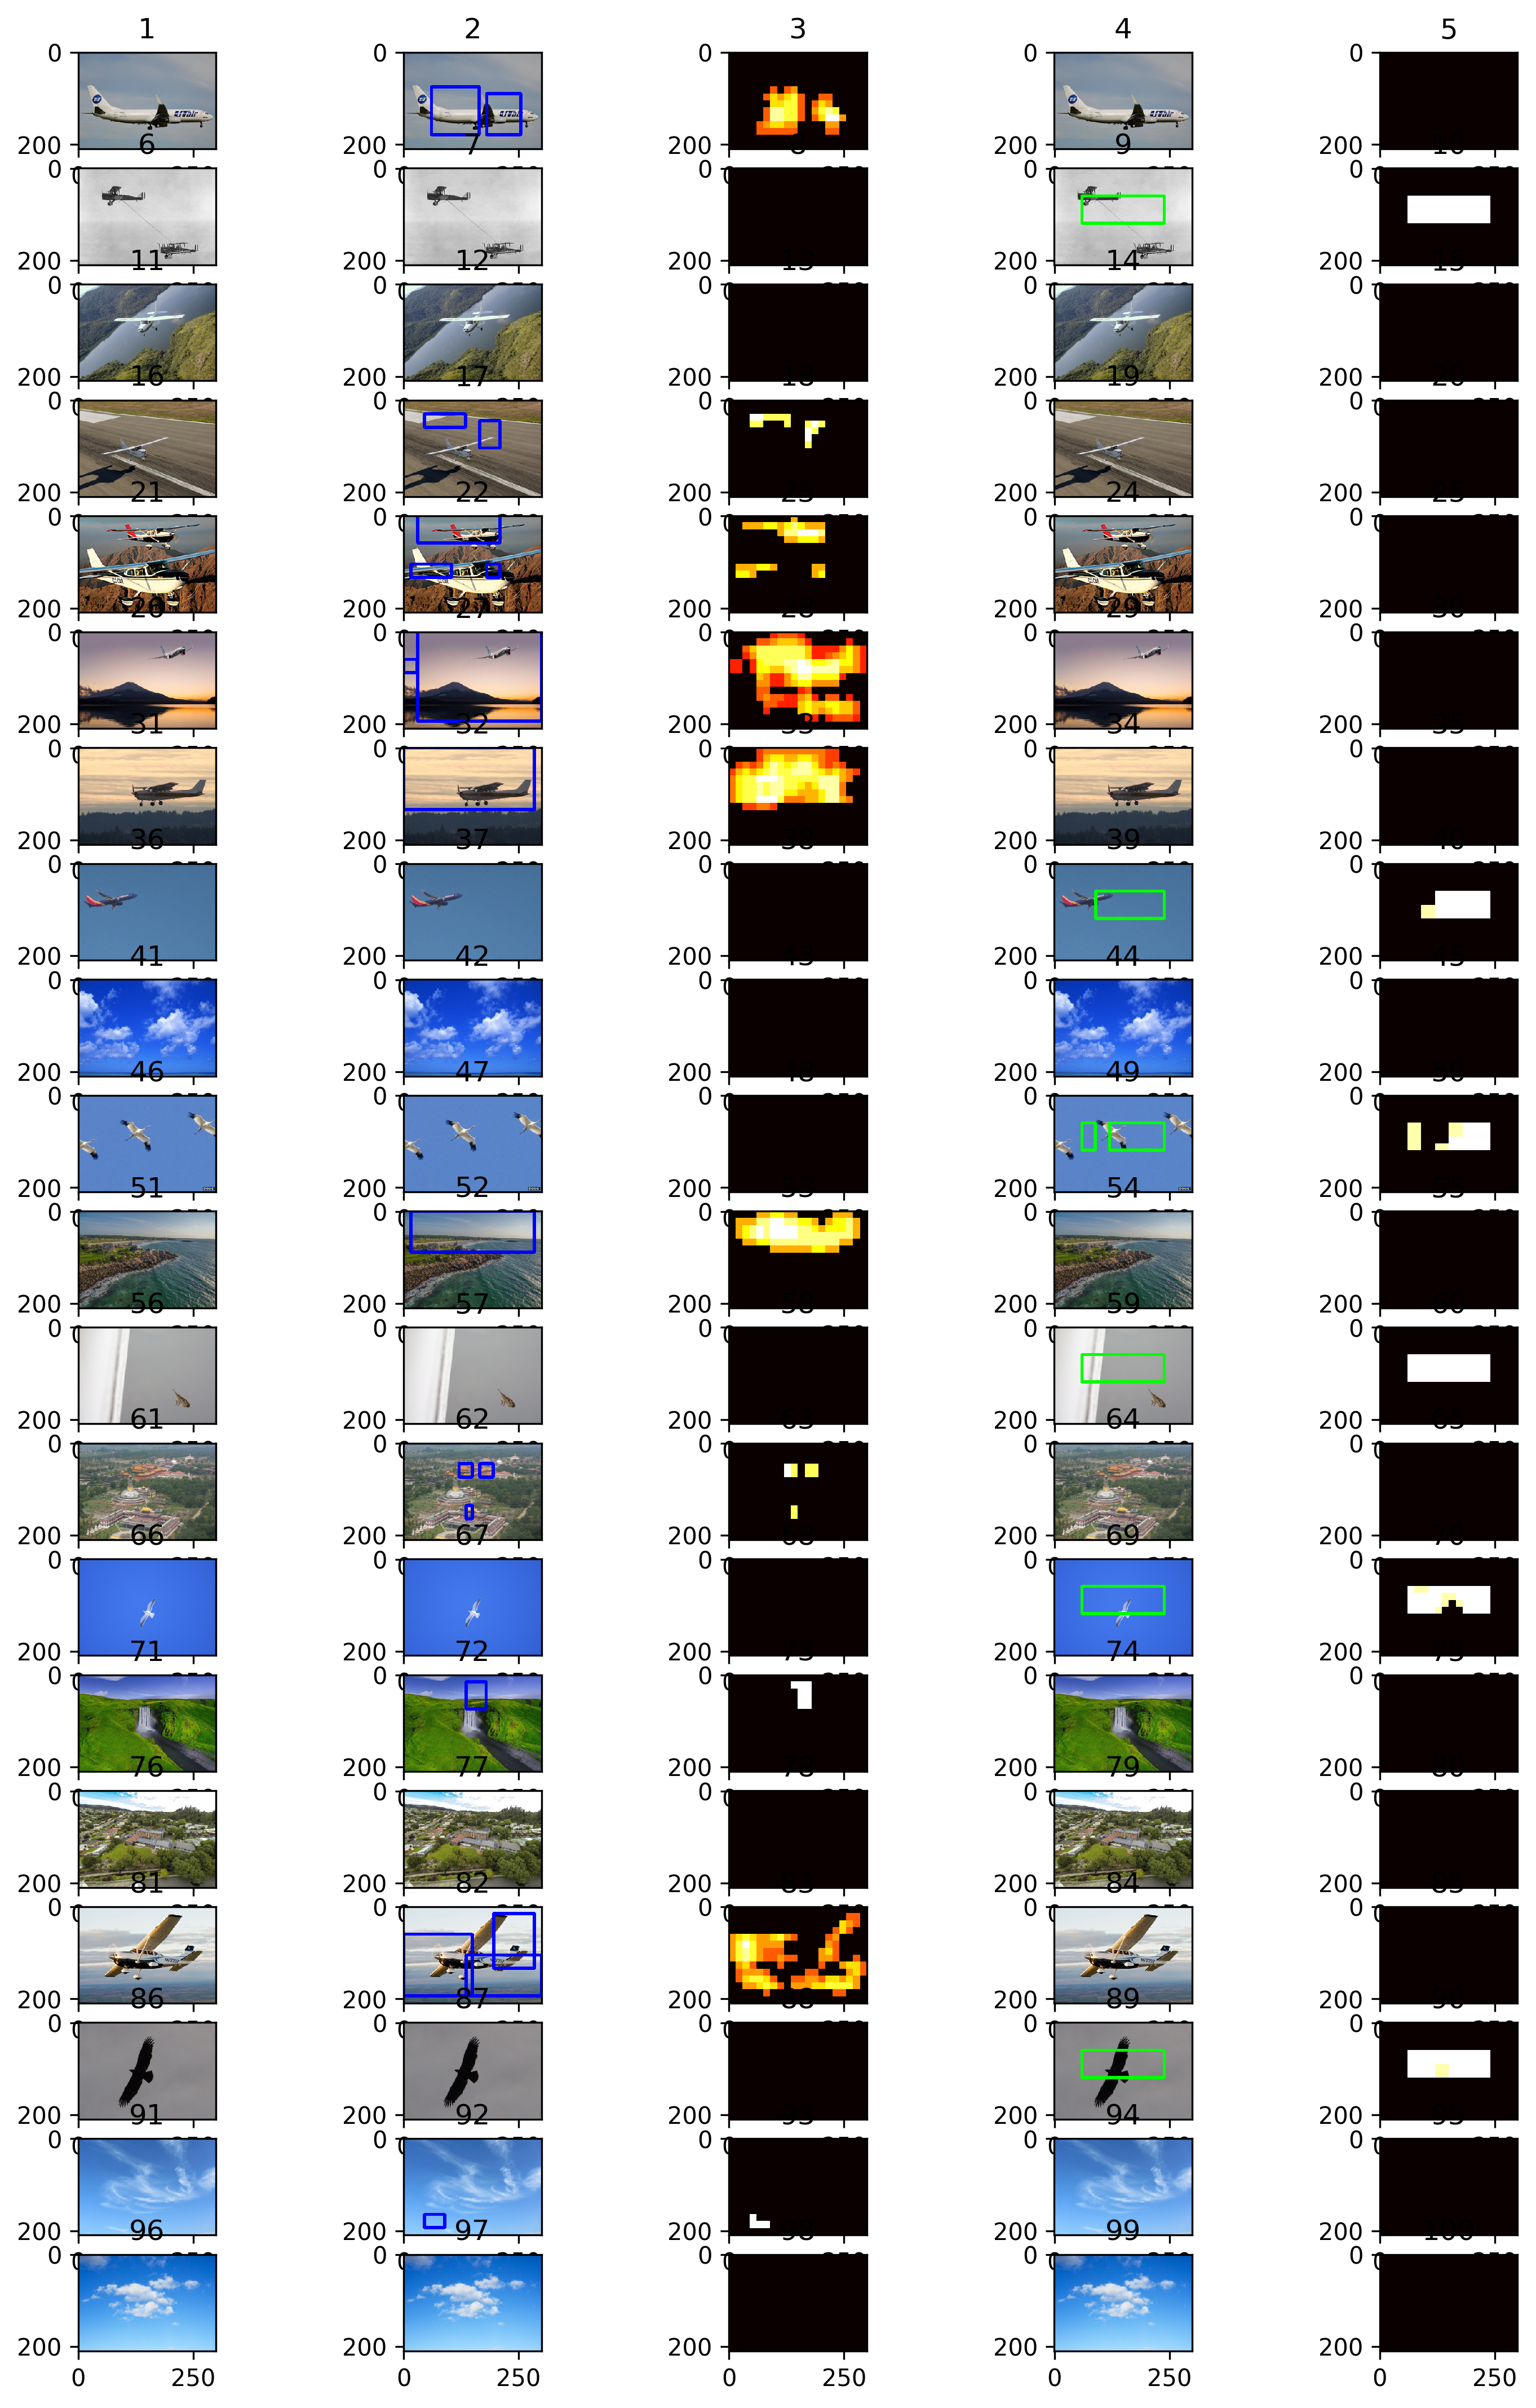

In [49]:
fig = plt.figure(figsize=(12,18), dpi=300)
just_visualize(fig, len(example_images), 5, out_images_labels)

# Column 1 - original test image |
# Column 2 - aircraft detections bounding boxes |
# Column 3 - aircraft detections heatmap - thresholded  |
# Column 4 - birds detections bounding boxes |
# Column 5 - birds detections heatmap - thresholded

In [50]:
#plt.imshow(window_img)
for i, img in enumerate(out_images_labels):
    plt.imsave('test_images_results/out_images_labels_2_SVM/'+str(i+1)+'.png',out_images_labels[i])